In [1]:
import numpy as np
import cv2
from cv2 import aruco

with np.load('Obtain_Groundtruth_location\\calibration_data.npz') as data:
    mtx = data['mtx']
    dist = data['dist']
def detect_position(image, mtx, dist):
    x = 250  # Side length of the square
    pts_known = np.array([[-x/2, -x/2], [x/2, -x/2], [x/2, x/2], [-x/2, x/2]], dtype='float32')
    frame_width = image.shape[1]
    frame_height = image.shape[0]

    # Define the ArUco marker dictionary
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
    parameters = aruco.DetectorParameters()

    # Undistort the image using calibration data
    # undistorted_frame = cv2.undistort(image, mtx, dist)
    frame = image

    # Convert to grayscale for marker detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect ArUco markers
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, _ = detector.detectMarkers(gray)

    # if ids is not None:
    #     img = cv2.aruco.drawDetectedMarkers(frame, corners, ids)
    #     for corner in corners:
    #         center = np.mean(corner[0], axis=0)
    #         cv2.circle(img, tuple(center.astype(int)), 5, (0, 255, 0), -1)  # Draw a circle at the center of the marker

    # cv2.imshow('ArUco Markers', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    if ids is not None:
        
        ids = ids.flatten()  # Flatten to a 1D array
        if len(ids) < 5:
            return None
        pts_detected = np.zeros((4, 2), dtype='float32')
        for i, marker_id in enumerate([0, 1, 2, 3]):
            idx = np.where(ids == marker_id)[0][0]
            pts_detected[i] = np.mean(corners[idx][0], axis=0)
        
        # Compute homography matrix
        H, _ = cv2.findHomography(pts_known, pts_detected)

        virtual_points = []
        # Process each detected marker
        for i, marker_id in enumerate(ids):
            if marker_id != 4:
                continue
            c = corners[i][0]
            center = np.mean(c, axis=0)
            # Transform marker coordinates to virtual plane
            pts_img = np.array([[center[0], center[1]]], dtype='float32')
            
            return cv2.perspectiveTransform(np.array([pts_img]), np.linalg.inv(H))

    return None

# Align the video

In [2]:
import os
import ipywidgets as widgets
from IPython.display import display, Video, HTML
import cv2
import csv
import numpy as np

# --- Global Variables ---
current_frame = 0
cap = None
video_path = None
total_frames = 0
fps = 30  # Default FPS
start_frame = 50
stop_frame = 100
mtx = None # Placeholder for camera matrix
dist = None # Placeholder for distortion coefficients

experiments_folder = 'experiments/experiments'

# --- Helper Functions ---

def get_frame(frame_num, cap):
    """Reads a specific frame from the video."""
    global total_frames
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    if not ret:
        print("Error reading frame or end of video.")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    _, encoded_frame = cv2.imencode('.jpg', frame)
    return encoded_frame.tobytes()

def update_video_display(frame_data, video_widget):
    """Updates the displayed video frame."""
    video_widget.value = frame_data
    with current_frame_output:
        current_frame_output.clear_output(wait=True)
        display(format_frame_info(current_frame, fps))

def format_frame_info(frame_num, fps):
    """Formats frame number and time information."""
    if fps > 0:  # Avoid division by zero
        seconds = frame_num / fps
        return f"Frame: {frame_num} ({seconds:.2f}s)"
    else:
        return f"Frame: {frame_num} (FPS not available)"

# --- UI Elements ---

# Get all subfolders
subfolders = [f.name for f in os.scandir(experiments_folder) if f.is_dir()]

# Dropdown
dropdown = widgets.Dropdown(
    options=subfolders,
    description='Subfolders:',
    disabled=False,
)

# Video Widget
video_widget = widgets.Image(format='jpeg', width=640, height=480)

# Current Frame Display
current_frame_output = widgets.Output()

# Buttons
forward_button = widgets.Button(description=">>")
backward_button = widgets.Button(description="<<")
forward_1s_button = widgets.Button(description="> 1s")
backward_1s_button = widgets.Button(description="< 1s")
forward_60s_button = widgets.Button(description="> 60s")
backward_60s_button = widgets.Button(description="< 60s")
load_button = widgets.Button(description="Load Video")
start_frame_button = widgets.Button(description="Set Start")
stop_frame_button = widgets.Button(description="Set Stop")
transform_frame_button = widgets.Button(description="Transform Image")
extract_location_button = widgets.Button(description="Extract Location")
# Output for Start/Stop Frame Information
start_frame_output = widgets.Output()
stop_frame_output = widgets.Output()

# --- Event Handlers ---

def on_load_clicked(b):
    """Loads the video."""
    global cap, video_path, current_frame, fps, total_frames, start_frame, stop_frame, mtx, dist
    current_frame = 0
    start_frame = 50
    stop_frame = 1500
    

    files = [f.name for f in os.scandir(os.path.join(experiments_folder, dropdown.value)) if f.is_file()]
    video_file = next((f for f in files if f.endswith('.mp4')), None)

    if video_file:
        video_path = os.path.join(experiments_folder, dropdown.value, video_file)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print("Error opening video.")
            return
        
        # Load camera parameters if available
        param_file = os.path.join(experiments_folder, dropdown.value, 'c922_params.npz')
        if os.path.exists(param_file):
            data = np.load(param_file)
            mtx, dist = data['mtx'], data['dist']
        else:
            print("Camera parameters not found. Using default values.")

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        initial_frame = get_frame(current_frame, cap)
        if initial_frame:
            update_video_display(initial_frame, video_widget)

        # Reset start/stop frame info
        with start_frame_output:
            start_frame_output.clear_output()
            print(format_frame_info(start_frame, fps))
        with stop_frame_output:
            stop_frame_output.clear_output()
            print(format_frame_info(stop_frame, fps))

    else:
        video_path = None
        print('No video file found.')

def on_forward_clicked(b):
    """Moves forward by one frame."""
    global current_frame, total_frames
    if cap and current_frame < total_frames - 1:
        current_frame += 1
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            update_video_display(frame_data, video_widget)

def on_backward_clicked(b):
    """Moves backward by one frame."""
    global current_frame
    if cap and current_frame > 0:
        current_frame -= 1
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            update_video_display(frame_data, video_widget)

def on_forward_1s_clicked(b):
    """Moves forward by 1 second."""
    global current_frame, fps, total_frames
    if cap:
        current_frame += int(fps)
        current_frame = min(current_frame, total_frames - 1)
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            update_video_display(frame_data, video_widget)

def on_backward_1s_clicked(b):
    """Moves backward by 1 second."""
    global current_frame, fps
    if cap:
        current_frame -= int(fps)
        current_frame = max(current_frame, 0)
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            update_video_display(frame_data, video_widget)

def on_forward_60s_clicked(b):
    """Moves forward by 60 seconds."""
    global current_frame, fps, total_frames
    if cap:
        current_frame += int(fps * 60)
        current_frame = min(current_frame, total_frames - 1)
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            update_video_display(frame_data, video_widget)

def on_backward_60s_clicked(b):
    """Moves backward by 60 seconds."""
    global current_frame, fps
    if cap:
        current_frame -= int(fps * 60)
        current_frame = max(current_frame, 0)
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            update_video_display(frame_data, video_widget)

def on_start_frame_clicked(b):
    """Sets the start frame."""
    global start_frame
    start_frame = current_frame
    with start_frame_output:
        start_frame_output.clear_output()
        print(format_frame_info(start_frame, fps))

def on_stop_frame_clicked(b):
    """Sets the stop frame."""
    global stop_frame
    stop_frame = current_frame
    with stop_frame_output:
        stop_frame_output.clear_output()
        print(format_frame_info(stop_frame, fps))

def on_transform_image_clicked(b):
    """Transforms the image."""
    global current_frame
    if cap:
        frame_data = get_frame(current_frame, cap)
        if frame_data:
            frame = cv2.imdecode(np.frombuffer(frame_data, np.uint8), cv2.IMREAD_COLOR)
            center_location = detect_position(frame, mtx, dist)
            if center_location is not None:
                _, encoded_frame = cv2.imencode('.jpg', frame)
                update_video_display(encoded_frame.tobytes(), video_widget)

def on_extract_location_clicked(b):
    """Extracts the location of the sound source."""
    global current_frame, start_frame, stop_frame
    location_data = []
    if cap:
        for frame_num in range(start_frame, stop_frame + 1):
            current_frame = frame_num
            frame_data = get_frame(current_frame, cap)
            if frame_data:
                frame = cv2.imdecode(np.frombuffer(frame_data, np.uint8), cv2.IMREAD_COLOR)
                center_location = detect_position(frame, mtx, dist)
                if center_location is not None:
                    _, encoded_frame = cv2.imencode('.jpg', frame)
                    update_video_display(encoded_frame.tobytes(), video_widget)
                    location_data.append((frame_num, center_location))
                else:
                    print(f"No ArUco marker detected in frame {frame_num}.")

    if len(location_data) > 0:
        with open('location_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Frame Number', 'X', 'Y'])
            for frame_num, loc in location_data:
                x = loc[0][0][0]  # Access the x coordinate
                y = loc[0][0][1]  # Access the y coordinate
                writer.writerow([frame_num, x, y])
        print("Location data saved to location_data.csv.")
        
# --- Attach Event Handlers ---

load_button.on_click(on_load_clicked)
forward_button.on_click(on_forward_clicked)
backward_button.on_click(on_backward_clicked)
forward_1s_button.on_click(on_forward_1s_clicked)
backward_1s_button.on_click(on_backward_1s_clicked)
forward_60s_button.on_click(on_forward_60s_clicked)
backward_60s_button.on_click(on_backward_60s_clicked)
start_frame_button.on_click(on_start_frame_clicked)
stop_frame_button.on_click(on_stop_frame_clicked)
transform_frame_button.on_click(on_transform_image_clicked)
extract_location_button.on_click(on_extract_location_clicked)
# --- Layout ---

buttons_60s = widgets.HBox([backward_60s_button, forward_60s_button])
buttons_1s = widgets.HBox([backward_1s_button, forward_1s_button])
buttons_frames = widgets.HBox([backward_button, forward_button])
buttons_start_stop = widgets.HBox([start_frame_button, stop_frame_button])
info_layout = widgets.HBox([
    widgets.VBox([widgets.Label("Start Frame:"), start_frame_output]),
    widgets.VBox([widgets.Label("Stop Frame:"), stop_frame_output]),
])

ui_layout = widgets.VBox([
    dropdown,
    load_button,
    video_widget,
    current_frame_output,
    buttons_60s,
    buttons_1s,
    buttons_frames,
    buttons_start_stop,
    info_layout,
    transform_frame_button,
    extract_location_button,
])

display(ui_layout)

No video file found.


# Align the audio

In [15]:
# get the highest peak in the first 20 seconds of the audio file
import numpy as np

def get_peak_time(start_time, end_time, audio):
    start_frame = int(start_time * 44100)
    end_frame = int(end_time * 44100)
    return start_frame, end_frame
    
    if end_frame > len(audio):
        end_frame = len(audio)

    signal_width = int(44100/2)
    audio = audio[start_frame:end_frame]
    peak = np.argmax(audio)
    peak_time = peak / 44100 + start_time
    start_peak = peak - signal_width
    end_peak = peak + signal_width
    
    if start_peak < 0:
        start_peak = 0
    if end_peak > len(audio):
        end_peak = len(audio)

    return start_peak, end_peak

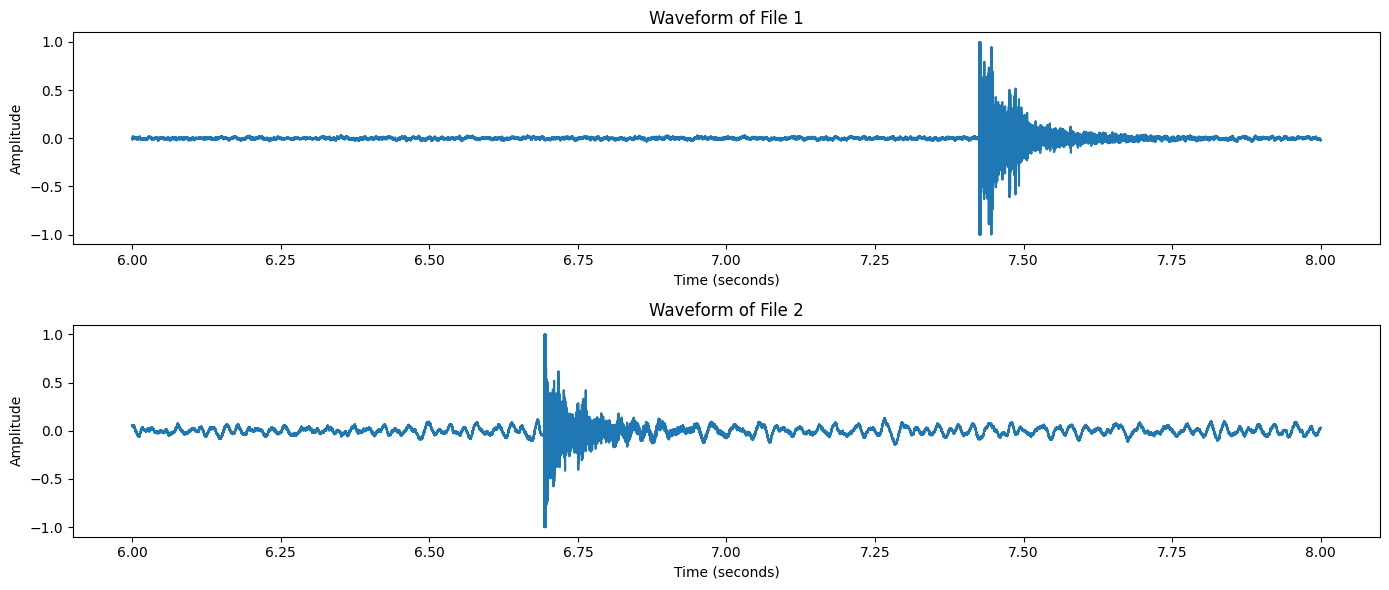

Best shift: 32548 samples
Minimum error: 0


In [46]:
# %pip install tqdm
import wave
from tqdm import tqdm
import numpy as np
import cupy as cp

def calculate_audio_error(signal1, signal2, start_time, stop_time, sample_rate):
    """
    Calculate the squared error between two audio signals within a specified time window.

    Parameters:
    signal1 (cupy array): The first audio signal.
    signal2 (cupy array): The second audio signal.
    start_time (float): The start time in seconds.
    stop_time (float): The stop time in seconds.
    sample_rate (int): The sample rate of the audio signals.

    Returns:
    float: The squared error between the two signals within the time window.
    """

    start_sample = int(start_time * sample_rate)
    end_sample = int(stop_time * sample_rate)

    signal1_sliced = signal1[start_sample:end_sample]
    signal2_sliced = signal2[start_sample:end_sample]

    if len(signal1_sliced) != len(signal2_sliced):
        raise ValueError("The sliced audio signals must have the same length.")

    error = cp.sum((signal1_sliced - signal2_sliced) ** 2)
    return error


def shift_audio(signal, shift_amount):
    """
    Shifts an audio signal by a given number of samples, padding with zeros.

    Parameters:
    signal (cupy array): The audio signal to shift.
    shift_amount (int): The number of samples to shift. 
                        Positive values shift to the right (delay), 
                        negative values shift to the left (advance).

    Returns:
    cupy array: The shifted audio signal with the same length as the input.
    """

    shifted_signal = cp.zeros_like(signal)

    if shift_amount > 0:  # Shift right (delay)
        shifted_signal[shift_amount:] = signal[:-shift_amount]
    elif shift_amount < 0:  # Shift left (advance)
        shifted_signal[:shift_amount] = signal[-shift_amount:]
    else:  # No shift
        shifted_signal = signal.copy()

    return shifted_signal


def find_best_shift(signal1, signal2, start_time, stop_time, sample_rate, max_shift_seconds=3):
    """
    Finds the best shift (in samples) for signal2 that minimizes the 
    squared error with signal1 within the specified time window.

    Parameters:
    signal1 (cupy array): The first audio signal.
    signal2 (cupy array): The second audio signal.
    start_time (float): The start time in seconds.
    stop_time (float): The stop time in seconds.
    sample_rate (int): The sample rate of the audio signals.
    max_shift_seconds (float): The maximum shift allowed in seconds (default: 3).

    Returns:
    tuple: (best_shift_amount, min_error) 
           - best_shift_amount (int): The shift amount in samples that resulted in the minimum error.
           - min_error (float): The minimum squared error achieved.
    """

    min_error = float('inf')
    best_shift_amount = 0
    max_shift_samples = int(max_shift_seconds * sample_rate)
    
    threshold = 0.1
    signal1 = cp.where(cp.abs(signal1) < threshold, 0, signal1)
    signal2 = cp.where(cp.abs(signal2) < threshold, 0, signal2)
    signal1 *= 4
    signal2 *= 4
    signal1 = cp.clip(signal1, -1, 1)
    signal2 = cp.clip(signal2, -1, 1)

    for shift_amount in tqdm(range(0, max_shift_samples + 1), desc="Finding best shift"):
        shifted_signal2 = shift_audio(signal2, shift_amount)
        error = calculate_audio_error(signal1, shifted_signal2, start_time, stop_time, sample_rate)
        
        if error < min_error:
            min_error = error
            best_shift_amount = shift_amount

    return best_shift_amount, min_error

file_1 = 'experiments/experiments/exp_1/audio_wav_files/1_1734631034.wav'
file_2 = 'experiments/experiments/exp_1/audio_wav_files/2_1734631035.wav'

import matplotlib.pyplot as plt

# Function to read audio file
def read_audio(file_path):
    with wave.open(file_path, 'r') as wf:
        num_channels = wf.getnchannels()
        framerate = wf.getframerate()
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        if wf.getsampwidth() == 2:
            audio_data = np.frombuffer(frames, dtype=np.int16)
        elif wf.getsampwidth() == 1:
            audio_data = np.frombuffer(frames, dtype=np.int8)
        else:
            raise ValueError("Unsupported sample width. Only 8-bit and 16-bit are currently supported.")
        audio_data = audio_data / np.max(np.abs(audio_data))
        if num_channels > 1:
            audio_data = audio_data[::num_channels]  # Take only the left channel
    return audio_data, framerate, num_channels
# Read audio files
audio_data_1, framerate_1, num_channels_1 = read_audio(file_1)
audio_data_2, framerate_2, num_channels_2 = read_audio(file_2)

# Define start and stop times for plotting
plot_start_time = 6  # in seconds
plot_stop_time = 8  # in seconds

# Convert times to sample indices
plot_start_sample_1 = int(plot_start_time * framerate_1)
plot_stop_sample_1 = int(plot_stop_time * framerate_1)
plot_start_sample_2 = int(plot_start_time * framerate_2)
plot_stop_sample_2 = int(plot_stop_time * framerate_2)

# Plot waveforms within the specified time window
plt.figure(figsize=(14, 6))
time_axis_1 = np.linspace(plot_start_time, plot_stop_time, num=(plot_stop_sample_1 - plot_start_sample_1))
time_axis_2 = np.linspace(plot_start_time, plot_stop_time, num=(plot_stop_sample_2 - plot_start_sample_2))

plt.subplot(2, 1, 1)
plt.plot(time_axis_1, audio_data_1[plot_start_sample_1:plot_stop_sample_1])
plt.title('Waveform of File 1')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time_axis_2, audio_data_2[plot_start_sample_2:plot_stop_sample_2])
plt.title('Waveform of File 2')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Move data to GPU
audio_data_1_gpu = cp.asarray(audio_data_1)
audio_data_2_gpu = cp.asarray(audio_data_2)

# Find the best shift on the GPU
start_time = 6
stop_time = 8
# best_shift, min_error = find_best_shift(audio_data_1_gpu, audio_data_2_gpu, start_time, stop_time, framerate_1, 1)
best_shift = 32548
min_error = 0
print(f"Best shift: {best_shift} samples")
print(f"Minimum error: {min_error}")

C:\Users\calvi\AppData\Local\Temp\ipykernel_31476\1944414532.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

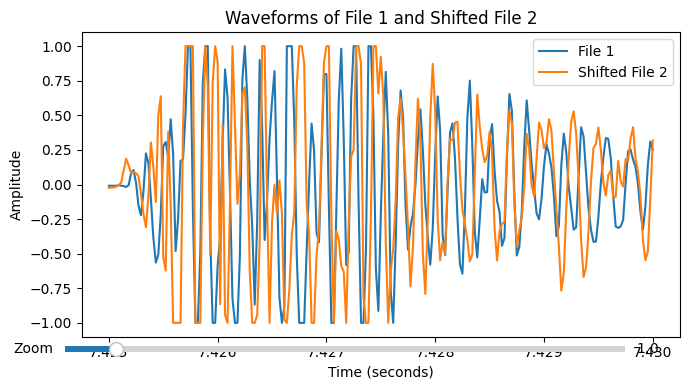

In [56]:
from matplotlib.widgets import Slider

# Define start and stop times for plotting

plot_start_time = 7.425  # in seconds
plot_stop_time = 7.43  # in seconds
# plot_start_time = 7.4
# plot_stop_time = 7.5
# Convert times to sample indices
plot_start_sample_1 = int(plot_start_time * framerate_1)
plot_stop_sample_1 = int(plot_stop_time * framerate_1)
plot_start_sample_2 = int(plot_start_time * framerate_2)
plot_stop_sample_2 = int(plot_stop_time * framerate_2)

# Plot waveforms within the specified time window
plt.figure(figsize=(14, 6))
time_axis_1 = np.linspace(plot_start_time, plot_stop_time, num=(plot_stop_sample_1 - plot_start_sample_1))
time_axis_2 = np.linspace(plot_start_time, plot_stop_time, num=(plot_stop_sample_2 - plot_start_sample_2))

threshold = 0.0
new_signal1 = np.where(np.abs(audio_data_1) < threshold, 0,  audio_data_1)
new_signal2 = np.where(np.abs(audio_data_2) < threshold, 0, audio_data_2)
new_signal1 *= 1
new_signal2 *= 1
new_signal1 = np.clip(new_signal1, -1, 1)
new_signal2 = np.clip(new_signal2, -1, 1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
plt.subplots_adjust(left=0.1, bottom=0.25)

# Shift audio_data_2 by best_shift amount
addition = -268
shifted_audio_data_2 = np.roll(new_signal2, best_shift + addition)

# Plot the waveforms
line1, = ax.plot(time_axis_1, new_signal1[plot_start_sample_1:plot_stop_sample_1], label='File 1')
line2, = ax.plot(time_axis_2, shifted_audio_data_2[plot_start_sample_2:plot_stop_sample_2], label='Shifted File 2')

ax.set_title('Waveforms of File 1 and Shifted File 2')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude')
ax.legend()

# Add sliders for zooming
axcolor = 'lightgoldenrodyellow'
ax_zoom = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor=axcolor)
slider_zoom = Slider(ax_zoom, 'Zoom', 0.1, 10.0, valinit=1.0)

def update(val):
    zoom = slider_zoom.val
    ax.set_xlim(plot_start_time, plot_start_time + (plot_stop_time - plot_start_time) / zoom)
    fig.canvas.draw_idle()

slider_zoom.on_changed(update)

plt.tight_layout()
plt.show()


Dropdown(description='Subfolders:', options=('exp_1', 'exp_10', 'exp_11', 'exp_12', 'exp_13', 'exp_14', 'exp_1…

Output()

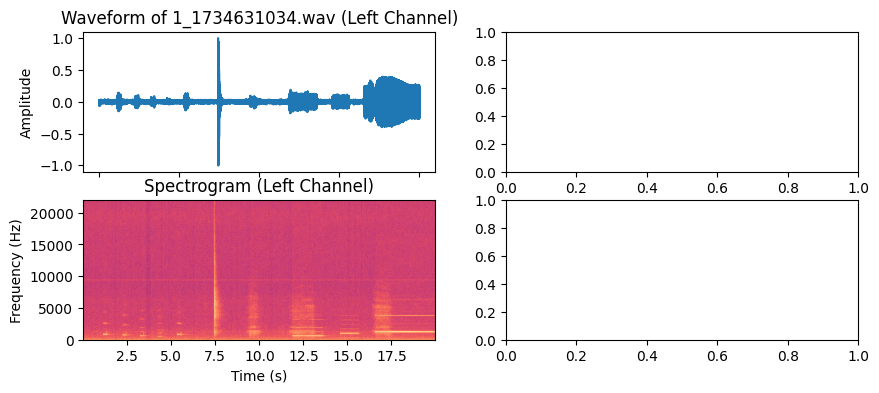

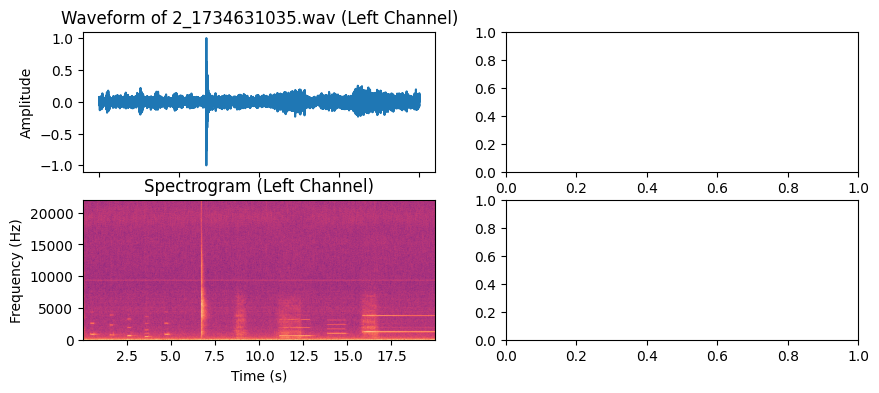

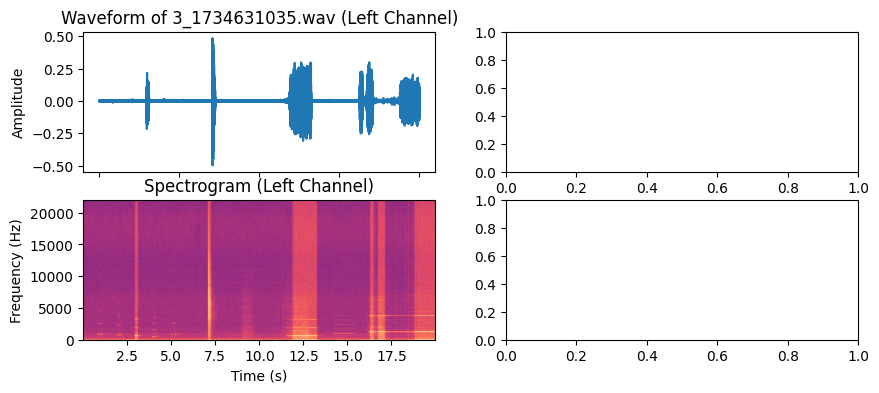

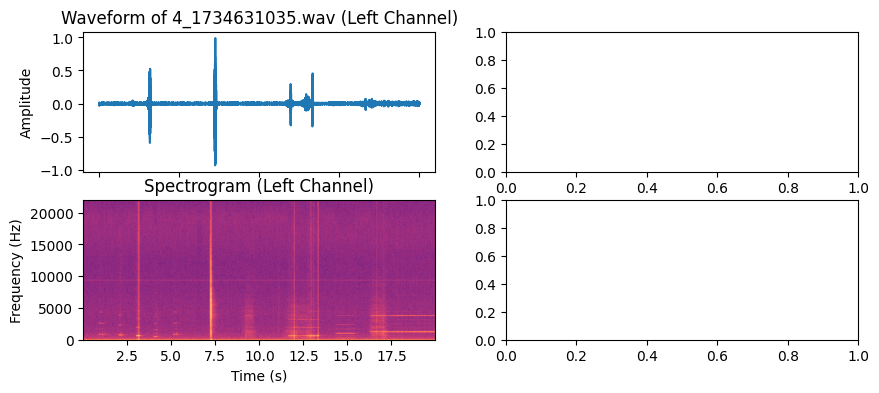

In [17]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import matplotlib.pyplot as plt
import wave
import numpy as np

experiments_folder = 'experiments/experiments'
subfolders = [f.name for f in os.scandir(experiments_folder) if f.is_dir()]

# Dropdown
dropdown = widgets.Dropdown(
    options=subfolders,
    description='Subfolders:',
    disabled=False,
)

# Output widget for displaying waveforms and audio players
out = widgets.Output()

def on_dropdown_change(change):
    """Handles the dropdown value change."""
    with out:
        clear_output(wait=True)

        audio_files = [f.name for f in os.scandir(os.path.join(experiments_folder, dropdown.value, 'audio_wav_files')) if f.is_file() and f.name.endswith('.wav')]

        if len(audio_files) < 4:
            print('Not enough audio files found.')
            return

        for i, audio_file in enumerate(audio_files[:4]):
            audio_path = os.path.join(experiments_folder, dropdown.value, 'audio_wav_files', audio_file)
            try:
                with wave.open(audio_path, 'r') as wf:
                    num_channels = wf.getnchannels()
                    framerate = wf.getframerate()
                    num_frames = wf.getnframes()

                    frames = wf.readframes(num_frames)

                    if wf.getsampwidth() == 2:
                        audio_data = np.frombuffer(frames, dtype=np.int16)
                    elif wf.getsampwidth() == 1:
                        audio_data = np.frombuffer(frames, dtype=np.int8)
                    else:
                        raise ValueError("Unsupported sample width. Only 8-bit and 16-bit are currently supported.")

                    audio_data = audio_data / np.max(np.abs(audio_data))
                    time = np.linspace(0, num_frames / framerate, num=num_frames)

                    # Handle stereo audio: plot left and right channels separately
                    if num_channels == 2:
                        fig, axs = plt.subplots(2, 2, figsize=(10, 4))
                        
                        begin_start_peak, end_start_peak = get_peak_time(0, 20, audio_data)
                        begin_end_peak, end_end_peak = get_peak_time(60, 120, audio_data)
                        print(begin_start_peak, end_start_peak)
                        print(begin_end_peak, end_end_peak)
                        # Left channel
                        
                        left_channel_data = audio_data[::2]
                        left_channel_trimmed = left_channel_data[begin_start_peak:end_start_peak]

                        time = np.linspace(0, len(left_channel_trimmed) / framerate, num=len(left_channel_trimmed))
                        axs[0, 0].plot(time, left_channel_trimmed)
                        axs[0, 0].set(title=f'Waveform of {audio_file} (Left Channel)')
                        axs[0, 0].set(xlabel='Time (s)', ylabel='Amplitude')
                        axs[0, 0].label_outer()
                        
                        # Spectrogram of the left channel
                        axs[1, 0].specgram(left_channel_trimmed, Fs=framerate, NFFT=1024, cmap=plt.cm.get_cmap('magma'))
                        axs[1, 0].set(title=f'Spectrogram (Left Channel)')
                        axs[1, 0].set(xlabel='Time (s)', ylabel='Frequency (Hz)')
                        axs[1, 0].label_outer()
                        

                        # Display audio player for the left channel
                        audio_left_label = widgets.Label(value="Audio left:")
                        display(audio_left_label)
                        display(Audio(data=left_channel_data, rate=framerate))

                        # Right channel
                        right_channel_data = audio_data[1::2]
                        right_channel_trimmed = right_channel_data[begin_end_peak:end_end_peak]
                        axs[0, 1].plot(time, right_channel_trimmed)
                        axs[0, 1].set(title=f'Waveform of {audio_file} (Right Channel)')
                        axs[0, 1].set(xlabel='Time (s)', ylabel='Amplitude')
                        axs[0, 1].label_outer()

                        # Spectrogram of the right channel
                        axs[1, 1].specgram(right_channel_trimmed, Fs=framerate, NFFT=1024, cmap=plt.cm.get_cmap('magma'))
                        axs[1, 1].set(title=f'Spectrogram (Right Channel)')
                        axs[1, 1].set(xlabel='Time (s)', ylabel='Frequency (Hz)')
                        axs[1, 1].label_outer()
                        
                        # Display audio player for the right channel
                        audio_right_label = widgets.Label(value="Audio right:")
                        display(audio_right_label)
                        display(Audio(data=right_channel_data, rate=framerate))

                        plt.tight_layout()
                        plt.show()
                    else:
                        # For mono, plot normally
                        fig, axs = plt.subplots(1, 1, figsize=(10, 2))
                        axs.plot(time, audio_data)
                        axs.set(title=f'Waveform of {audio_file}')
                        axs.set(xlabel='Time (s)', ylabel='Amplitude')
                        axs.label_outer()
                        plt.tight_layout()
                        plt.show()

                        # Display audio player for mono
                        display(Audio(data=audio_data, rate=framerate))

            except Exception as e:
                print(f"Error loading or displaying {audio_file}: {e}")

# Distance Input
distance_label_1 = widgets.Label(value="Distance microphone 1 (cm):")
distance_input_1 = widgets.FloatText(
    value=0.0,
    disabled=False,
)

distance_label_2 = widgets.Label(value="Distance microphone 2 (cm):")
distance_input_2 = widgets.FloatText(
    value=0.0,
    disabled=False,
)

distance_label_3 = widgets.Label(value="Distance microphone 3 (cm):")
distance_input_3 = widgets.FloatText(
    value=0.0,
    disabled=False,
)

distance_label_4 = widgets.Label(value="Distance microphone 4 (cm):")
distance_input_4 = widgets.FloatText(
    value=0.0,
    disabled=False,
)

distance_input_1 = widgets.HBox([distance_label_1, distance_input_1])
distance_input_2 = widgets.HBox([distance_label_2, distance_input_2])
distance_input_3 = widgets.HBox([distance_label_3, distance_input_3])
distance_input_4 = widgets.HBox([distance_label_4, distance_input_4])

dropdown.observe(on_dropdown_change, names='value')

display(dropdown, distance_input_1, distance_input_2, distance_input_3, distance_input_4, out)

on_dropdown_change({'new': dropdown.value})

In [2]:
import os
import subprocess

# Get all subfolders in the "experiments" folder
experiments_folder = 'experiments\\experiments'  # Correct the path if needed
subfolders = [f.name for f in os.scandir(experiments_folder) if f.is_dir()]

# Check each subfolder for a file ending with ".avi"
avi_files = {}
mp4_files = {}
for i, subfolder in enumerate(subfolders):
    if i > 0:
        break
    files = [f.name for f in os.scandir(os.path.join(experiments_folder, subfolder)) if f.is_file()]
    avi_file = next((f for f in files if f.endswith('.avi')), None)
    if avi_file:
        avi_file_path = os.path.join(experiments_folder, subfolder, avi_file)
        output_file_path = os.path.splitext(avi_file_path)[0] + '.mp4'

        # Use subprocess to run ffmpeg command
        try:
            subprocess.run([
                'C:\\Users\\calvi\\Downloads\\ffmpeg-7.1-essentials_build\\ffmpeg-7.1-essentials_build\\bin\\ffmpeg.exe',
                '-i', avi_file_path,
                '-ac', '2',
                '-b:v', '2000k',
                '-c:a', 'aac',
                '-c:v', 'libx264',
                '-b:a', '160k',
                '-vprofile', 'high',
                '-bf', '0',
                '-strict', 'experimental',
                '-f', 'mp4',
                output_file_path
            ], check=True)  # check=True raises an error if ffmpeg fails
            avi_files[subfolder] = avi_file_path
            mp4_files[subfolder] = output_file_path
            print(f"Successfully converted {avi_file_path} to {output_file_path}")
        except subprocess.CalledProcessError as e:
            print(f"Error converting {avi_file_path}: {e}")

print(avi_files)
print(mp4_files)

Successfully converted experiments\experiments\exp_1\recorded_20241219_185715_177641.avi to experiments\experiments\exp_1\recorded_20241219_185715_177641.mp4
{'exp_1': 'experiments\\experiments\\exp_1\\recorded_20241219_185715_177641.avi'}
{'exp_1': 'experiments\\experiments\\exp_1\\recorded_20241219_185715_177641.mp4'}
